In [20]:
import mdtraj
import numpy as np
import matplotlib.pyplot as plt
import nglview
import sys
sys.path.append('../')
from Simulation.helper_functions import get_dihedrals_by_name
from Simulation.helper_functions import minimize_mol
from rdkit import Chem
from rdkit.Chem import AllChem
import nglview
import yaml

solvent_dict = yaml.load(open("../Simulation/solvents.yml"), Loader=yaml.FullLoader)[
    "solvent_mapping_dict"
]

from typing import DefaultDict
import pandas as pd
from matplotlib.patches import Patch
import matplotlib as mpl
import matplotlib.cm as cm


In [21]:
def probability_to_kjmol_dif(p1,p2):
    return -8.314 * 298 * np.log(p1/p2) / 1000

def kjmol_to_prop(energies):
    kT = 2.479
    props = np.exp(-energies/kT) / np.sum(np.exp(-energies/kT))

    return props

def get_color_from_sd(sd):
    return cm.RdBu(sd/80)

In [34]:
minimization_folder = "/fileserver/pine/pine8/kpaul/multi_solvent_pub/data/Minimizations/MB_results/"
plot_folder = "/fileserver/birch/birch1/kpaul/pine8/multi_solvent_pub/manuscript/Plots/"
df = pd.read_csv("MB_experimental_references.csv", index_col=0)
labels = ["A%i" % (i+1) for i in range(4)] + ["B%i" % (i+1) for i in range(4)] + ["C%i" % (i+1) for i in range(7)] + ["D%i" % (i+1) for i in range(7)]

In [23]:
solvents = ['Chloroform','acetone','acetonitrile','Ethylacetate','THF','DCM','Ethanol','Methanol','DMSO']


model_results = []

for ad in ["","_gbneck2"]:
    results = DefaultDict(dict)

    for idx in range(22):

        for solvent in solvents:
            evaluated_truths = []
            cluster_center_traj = mdtraj.load(f"{minimization_folder}/{labels[idx]}/{labels[idx]}{ad}_{solvent}_cluster_center.h5")
            cluster_center_free_energies = np.load(f"{minimization_folder}/{labels[idx]}/{labels[idx]}{ad}_{solvent}_cluster_center_free_energy.npy")

            dhcalc = get_dihedrals_by_name(cluster_center_traj, *'C4 N1 C5 H3'.split(' '))

            closed_states = []
            open_states = []

            for i in range(cluster_center_traj.n_frames):

                if (dhcalc[i] < -2) or (dhcalc[i] > 2):
                    closed_states.append(cluster_center_free_energies[i])
                else:
                    open_states.append(cluster_center_free_energies[i])

            props = kjmol_to_prop(np.array(open_states+closed_states))
            props1 = np.sum(props[:len(open_states)])
            props2 = np.sum(props[len(open_states):])
            results[idx][solvent] = probability_to_kjmol_dif(props1,props2)
    model_results.append(results)

gnn_results = model_results[0]
gbneck_results = model_results[1]

/localhome/kpaul/.conda/envs/GNNImplicitSolvent/lib/python3.10/site-packages/mdtraj/core/trajectory.py:438: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


In [24]:
# set font size
fs = 6
params = {'axes.labelsize': fs,'axes.titlesize':fs,'legend.fontsize': fs, 'xtick.labelsize': fs, 'ytick.labelsize': fs, "font.size": fs,'axes.linewidth': 0.2,'ytick.major.size': 2,'xtick.major.size': 3.5,}
mpl.rcParams.update(params)

/localhome/kpaul/.conda/envs/GNNImplicitSolvent/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)
/localhome/kpaul/.conda/envs/GNNImplicitSolvent/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


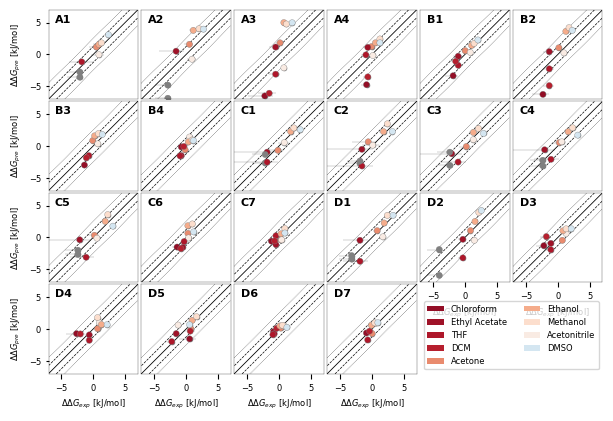

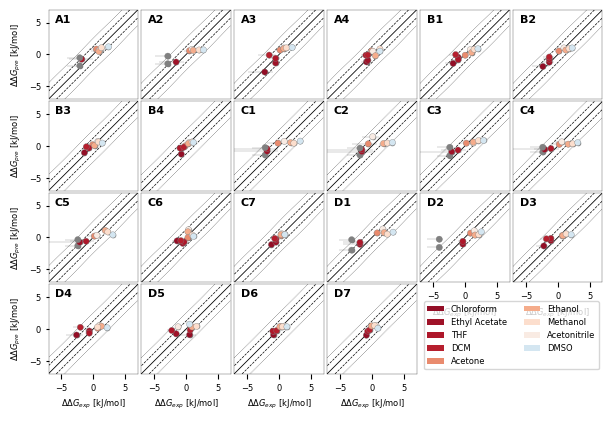

In [25]:
cmt = 1/2.54

all_res = []
for ad,results in zip(["","_gbneck2"],model_results):

    fig, axd = plt.subplot_mosaic([[labels[j+i*6] if (j+i*6 < 22) else "legend" for j in range(6)] for i in range(4)],
                              figsize=(18.2*cmt,12*cmt),empty_sentinel="EMPTY",
                            )

    all_exp = []
    all_pre = []

    for idx in range(22):

        experimental_references = {i:eval(df[labels[idx]][i].replace("nan","-100")) for i in solvents}

        ax = axd[labels[idx]]
        pre = np.array([results[idx][i] for i in solvents])
        exp = np.array([experimental_references[i][0] for i in solvents])
        exp = np.array([i if i != -100 else np.nan for i in exp])
        colors = {i:get_color_from_sd(solvent_dict[i]['dielectric']) for i in solvents}
        colors = {i:colors[i] if not ((experimental_references[i][1]==0) or (experimental_references[i][2]==0))  else "grey" for i in solvents }
        colors = [colors[i] for i in solvents]

        pre = pre - np.nanmean(pre)
        exp = exp - np.nanmean(exp)
        all_pre.append(np.array(pre[exp==exp],dtype=float))
        all_exp.append(exp[exp==exp])

        xerr_u = [experimental_references[i][1] for i in solvents]
        xerr_l = [experimental_references[i][2] for i in solvents]

        xmin = -7
        xmax = 7

        xerr = [np.array(xerr_u),np.array(xerr_l)]
        ax.errorbar(exp,pre,xerr=xerr,c="grey",zorder=0,linewidth=0.25,fmt=".")
        ax.scatter(exp,pre,c=colors,s=20,edgecolor="grey",linewidth=0.25)

        kbt = 2.5/2
        ax.axis("square")
        ax.plot([xmin,xmax],[xmin,xmax],c="black",zorder=0,linewidth=1.5*cmt)
        ax.plot([xmin,xmax],[xmin+kbt,xmax+kbt],c="black",zorder=0,linestyle="--",linewidth=1.25*cmt)
        ax.plot([xmin,xmax],[xmin-kbt,xmax-kbt],c="black",zorder=0,linestyle="--",linewidth=1.25*cmt)
        ax.plot([xmin,xmax],[xmin+2*kbt,xmax+2*kbt],c="black",zorder=0,linestyle="dotted",linewidth=1*cmt)
        ax.plot([xmin,xmax],[xmin-2*kbt,xmax-2*kbt],c="black",zorder=0,linestyle="dotted",linewidth=1*cmt)
        ax.text(-6,5,labels[idx],fontsize=8,weight="bold")

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax.set_xticks([-5,0,5])
        ax.set_yticks([-5,0,5])

        ax.set_xlabel(r"$\Delta \Delta G_{exp}$ [kJ/mol]")
        ax.set_ylabel(r"$\Delta \Delta G_{pre}$ [kJ/mol]")
        ax.set_xlim(xmin,xmax)
        ax.set_ylim(xmin,xmax)
        # ax.set_aspect('equal')

    ax = axd["legend"]
    # add legend for colors
    legend_solvents = ['Chloroform','Ethylacetate','THF','DCM','acetone','Ethanol',"Methanol",'acetonitrile','DMSO']
    ax.legend(handles=[Patch(facecolor=get_color_from_sd(solvent_dict[solvent]['dielectric']),label=solvent_dict[solvent]['nice_name']) for solvent in legend_solvents],loc="lower center",ncol=2)
    ax.axis("off")

    for key in ['D%i' % (i+2) for i in range(6)]:
        axd[key].get_xaxis().set_visible(True)

    for key in ['A1','B3','C5','D4']:
        axd[key].get_yaxis().set_visible(True)


    plt.subplots_adjust(wspace=0.025, hspace=0.025)
    plt.savefig(f"{plot_folder}/MB_results{ad}.pdf",bbox_inches="tight")
    all_res.append((all_exp,all_pre))

In [26]:
from scipy.stats import pearsonr, linregress
all_exp, all_pre = all_res[0]
pearsons = [pearsonr(all_exp[i],all_pre[i]).statistic for i in range(22)]
slopes = [np.log10(linregress(all_exp[i],all_pre[i]).slope)for i in range(22)]

all_exp, all_pre = all_res[1]
pearsons_gb = [pearsonr(all_exp[i],all_pre[i]).statistic for i in range(22)]
slopes_gb = [np.log10(linregress(all_exp[i],all_pre[i]).slope)for i in range(22)]

In [27]:
# make wilcoxon test
from scipy.stats import wilcoxon
print(wilcoxon(pearsons,pearsons_gb,alternative="greater"),np.median(pearsons),np.median(pearsons_gb))
print(wilcoxon(slopes),np.median(slopes))
print(wilcoxon(slopes_gb),wilcoxon(slopes_gb,alternative="less"),np.median(slopes_gb))

WilcoxonResult(statistic=184.0, pvalue=0.03170967102050781) 0.8631831031585442 0.8553471300127469
WilcoxonResult(statistic=93.0, pvalue=0.2902231216430664) 0.047177369691956794
WilcoxonResult(statistic=0.0, pvalue=4.76837158203125e-07) WilcoxonResult(statistic=0.0, pvalue=2.384185791015625e-07) -0.36483095774002483


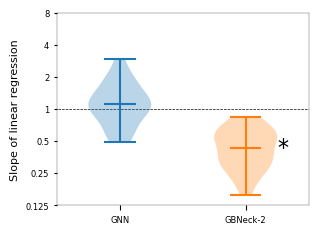

In [28]:
# chage font size
plt.rcParams.update({'font.size': 8})
fig,axd = plt.subplot_mosaic([["plot"]],figsize=(3.25,2.5))

ax = axd["plot"]

violin_parts = ax.violinplot(np.array(slopes,dtype=float),showmedians=True,positions=[0])

ax.violinplot(np.array(slopes_gb,dtype=float),showmedians=True,positions=[1])
ax.hlines(0,-2,2,linestyle="--",linewidth=0.5,colors="black",zorder=0)
log_labels = [0.125,0.25,0.5,1,2,4,8]
ax.set_yticks(np.log10(log_labels),log_labels)
ax.set_xticks([0,1],["GNN","GBNeck-2"])
ax.set_xlim(-0.5,1.5)
ax.set_ylabel("Slope of linear regression")
ax.text(1.25,np.median(slopes_gb),f"*",ha="left",va="center", fontsize=16)
fig.savefig(f"{plot_folder}/MB_slope_comparison.pdf",bbox_inches="tight")

In [29]:
10 ** 0.04, 10 ** -0.36483095774002483

(1.096478196143185, 0.43168707149771324)

## alternative Visulization

/tmp/ipykernel_1425380/2049872354.py:51: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(e,p,c=c,s=30,edgecolor=ec,linewidth=lwp,marker=s)
/tmp/ipykernel_1425380/2049872354.py:51: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(e,p,c=c,s=30,edgecolor=ec,linewidth=lwp,marker=s)


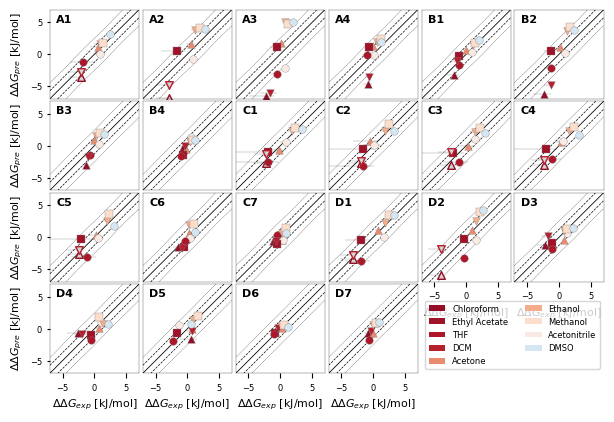

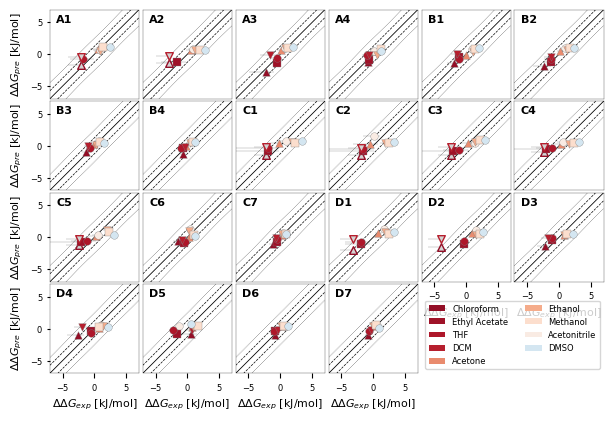

In [37]:
cmt = 1/2.54

all_res = []
for ad,results in zip(["","_gbneck2"],model_results):

    fig, axd = plt.subplot_mosaic([[labels[j+i*6] if (j+i*6 < 22) else "legend" for j in range(6)] for i in range(4)],
                              figsize=(18.2*cmt,12*cmt),empty_sentinel="EMPTY",
                            )

    all_exp = []
    all_pre = []

    for idx in range(22):

        experimental_references = {i:eval(df[labels[idx]][i].replace("nan","-100")) for i in solvents}

        ax = axd[labels[idx]]
        pre = np.array([results[idx][i] for i in solvents])
        exp = np.array([experimental_references[i][0] for i in solvents])
        exp = np.array([i if i != -100 else np.nan for i in exp])
        colors = {i:get_color_from_sd(solvent_dict[i]['dielectric']) for i in solvents}
        edge_colors = {i:"grey" if not ((experimental_references[i][1]==0) or (experimental_references[i][2]==0)) else colors[i] for i in solvents }
        colors = {i:colors[i] if not ((experimental_references[i][1]==0) or (experimental_references[i][2]==0))  else "grey" for i in solvents }
        colors = [colors[i] for i in solvents]
        edge_colors = [edge_colors[i] for i in solvents]

        pre = pre - np.nanmean(pre)
        exp = exp - np.nanmean(exp)
        all_pre.append(np.array(pre[exp==exp],dtype=float))
        all_exp.append(exp[exp==exp])

        xerr_u = [experimental_references[i][1] for i in solvents]
        xerr_l = [experimental_references[i][2] for i in solvents]

        xmin = -7
        xmax = 7

        xerr = [np.array(xerr_u),np.array(xerr_l)]
        ax.errorbar(exp,pre,xerr=xerr,c="grey",zorder=0,linewidth=0.25,fmt=".",markersize=1)
        # Give each point a distinct symbol
        # ax.scatter(exp,pre,c=colors,s=20,edgecolor="grey",linewidth=0.25)
        symbols = ["^","v","<",">","^","v","<",">","^"]
        symbols = ["h","p","o","H","o","p","h","H","o"]
        symbols = ["^","^","o","s","o","v","v","s","o"]
        for e,p,c,s,ec in zip(exp,pre,colors,symbols,edge_colors):
            if ec != "grey":
                lwp = 1.00
                c = "lightgrey"
            else:
                lwp = 0.25
            ax.scatter(e,p,c=c,s=30,edgecolor=ec,linewidth=lwp,marker=s)

        kbt = 2.5/2
        ax.axis("square")
        ax.plot([xmin,xmax],[xmin,xmax],c="black",zorder=0,linewidth=1.5*cmt)
        ax.plot([xmin,xmax],[xmin+kbt,xmax+kbt],c="black",zorder=0,linestyle="--",linewidth=1.25*cmt)
        ax.plot([xmin,xmax],[xmin-kbt,xmax-kbt],c="black",zorder=0,linestyle="--",linewidth=1.25*cmt)
        ax.plot([xmin,xmax],[xmin+2*kbt,xmax+2*kbt],c="black",zorder=0,linestyle="dotted",linewidth=1*cmt)
        ax.plot([xmin,xmax],[xmin-2*kbt,xmax-2*kbt],c="black",zorder=0,linestyle="dotted",linewidth=1*cmt)
        ax.text(-6,5,labels[idx],fontsize=8,weight="bold")

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax.set_xticks([-5,0,5])
        ax.set_yticks([-5,0,5])

        ax.set_xlabel(r"$\Delta \Delta G_{exp}$ [kJ/mol]")
        ax.set_ylabel(r"$\Delta \Delta G_{pre}$ [kJ/mol]")
        ax.set_xlim(xmin,xmax)
        ax.set_ylim(xmin,xmax)
        # ax.set_aspect('equal')

    ax = axd["legend"]
    # add legend for colors
    legend_solvents = ['Chloroform','Ethylacetate','THF','DCM','acetone','Ethanol',"Methanol",'acetonitrile','DMSO']
    ax.legend(handles=[Patch(facecolor=get_color_from_sd(solvent_dict[solvent]['dielectric']),label=solvent_dict[solvent]['nice_name']) for solvent in legend_solvents],loc="lower center",ncol=2)
    ax.axis("off")

    for key in ['D%i' % (i+2) for i in range(6)]:
        axd[key].get_xaxis().set_visible(True)

    for key in ['A1','B3','C5','D4']:
        axd[key].get_yaxis().set_visible(True)


    plt.subplots_adjust(wspace=0.025, hspace=0.025)
    plt.savefig(f"{plot_folder}/MB_results{ad}_marker.pdf",bbox_inches="tight")
    all_res.append((all_exp,all_pre))

In [68]:
# Sort solvents based on dielectric constant
df = pd.DataFrame(solvent_dict)
df = df.T
df.sort_values("dielectric",inplace=True,ascending=False)

solvent_s = ""
for s in df.values[:,-1]:
    solvent_s += f"{s.lower()}, "
solvent_s

'tip3p, dmso, glycerin, sulfolane, dmf, nitromethane, acetonitrile, dmpu, nitrobenzene, methanol, nmp, propionitrile, hmpa, 2-nitropropane, benzonitrile, ethanol, acetone, ipa, pyridine, octanol, trifluorotoluene, dcm, thf, dme, ethyl acetate, acetic acid, butyl formate, chloroform, mtbe, diethyl ether, oxylol, toluene, benzene, carbon tetrachloride, 1,4-dioxane, hexafluoroacetone, hexafluorobenzene, cyclohexane, hexane, '